# Card Classification

Dataset bertujuan untuk klasifikasi 53 kartu remi

## Load data and initial config

In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2
from skimage.feature import hog, local_binary_pattern

In [2]:
train_data_dir = './train/'
test_data_dir = './test/'
valid_data_dir = './valid/'
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir, ts_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)
    # valid dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)
    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

train_df, valid_df, test_df = create_df(train_data_dir, valid_data_dir, test_data_dir)

## EDA (Exploratory Data Analysis)

In [3]:
def plot_label_count (df, column, xaxis_label, yaxis_label, plot_title):
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()
    values=vcounts.tolist()
    lcount=len(labels)
    if lcount>53:
        print('The number of labels is >53, no plot will be produced')
    else:
        width=lcount * 4
        width=np.min([width, 20])
        plt.figure(figsize=(width,5))
        form = {'family': 'serif', 'color': 'blue', 'size': 25}
        plt.bar(labels, values)
        plt.title(plot_title, fontsize= 24, color='blue')
        plt.xticks(rotation=90, fontsize=18)
        plt.yticks(fontsize=18)
        plt.xlabel(xaxis_label, fontdict=form)
        plt.ylabel(yaxis_label, fontdict=form)
        plt.show()

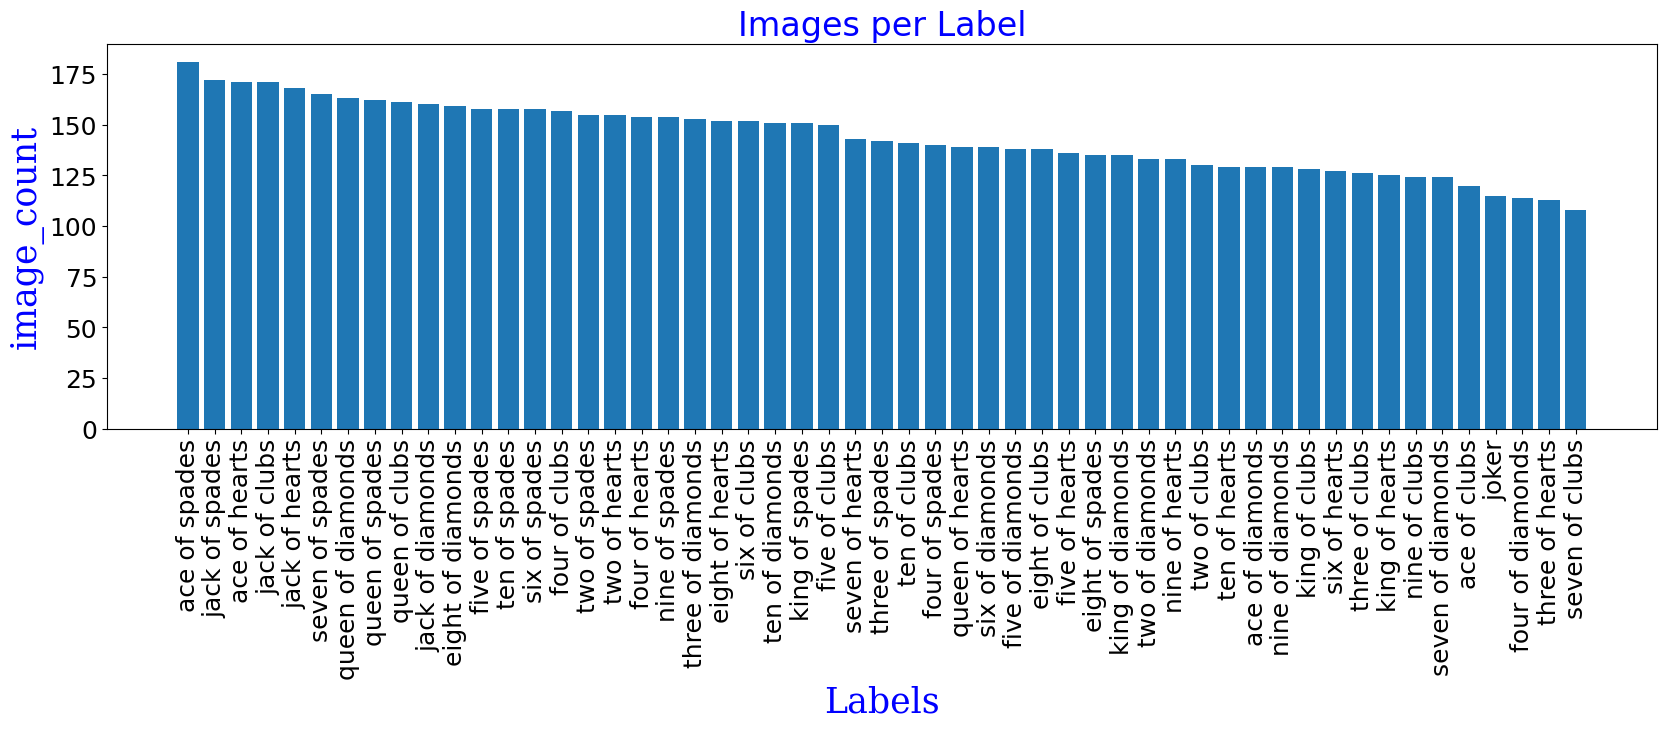

In [4]:
xaxis_label='Labels'
yaxis_label= 'image_count'
plot_title='Images per Label'
plot_label_count (train_df, 'labels', xaxis_label, yaxis_label, plot_title)

In [5]:
cv2.imread('/content/test/five of clubs/1.jpg')

## Preprocessing Data

In [6]:
# def reduce_noise_each_image(df):
#   df=df.copy()
#   for i in range(len(df)):
#     img=cv2.imread(df['filepaths'][i])
#     img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
#     img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
#     img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
#     cv2.imwrite(df['filepaths'][i], img_output)
#   return df

#   train_df=reduce_noise_each_image(train_df)
#   valid_df=reduce_noise_each_image(valid_df)
#   test_df=reduce_noise_each_image(test_df)

In [7]:
# def preprocess_canny(df):
#   df=df.copy()
#   for i in range(len(df)):
#     img=cv2.imread(df['filepaths'][i])
#     edges = cv2.Canny(img,100,200)
#     cv2.imwrite(df['filepaths'][i], edges)
#   return df

# train_df=preprocess_canny(train_df)
# valid_df=preprocess_canny(valid_df)
# test_df=preprocess_canny(test_df)


## Feature Extraction

In [8]:
def hu_moments(image):
    # Convert image to grayscale if it isn't already
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate Hu Moments
    moments = cv2.moments(image)
    hu_moments = cv2.HuMoments(moments)
    hu_moments = hu_moments.flatten()

    return hu_moments

In [9]:
sample_1 = cv2.imread(train_df['filepaths'][0])
sample_1 = cv2.cvtColor(sample_1, cv2.COLOR_BGR2GRAY)
hu_moment = hu_moments(sample_1)
print(hu_moment)

[ 1.48379994e-02  4.20668267e-06  3.58848512e-07  8.28241924e-08
  7.53982968e-15  1.52929618e-10 -1.21257906e-14]


In [10]:
import cv2
from skimage.feature import daisy
sample_1 = cv2.imread(train_df['filepaths'][1])
sample_1 = cv2.cvtColor(sample_1, cv2.COLOR_BGR2GRAY)
descs = daisy(sample_1, step=90, radius=15, rings=1, histograms=4, orientations=8, visualize=False)
print(descs.shape)

(3, 3, 40)


In [11]:
R = 1
P = 8
grid_size = (2, 2)
n_bins = P*2 + 2

In [12]:
import tqdm
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern

X_train = []
y_train = []
for i in tqdm.tqdm(range(len(train_df))):
    image_path = train_df['filepaths'][i]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # use HOG
    hog_features = hog(image,orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
    # use lbph
    lbp = local_binary_pattern(image, P, R, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins))
    hog_features = np.append(hog_features, hist)
    # daisy_features = daisy(image, step=90, radius=15, rings=1, histograms=4, orientations=8, visualize=False)
    # append hu moments
    # hog_features = np.append(hog_features, hu_moments(image))
    # append flattened daisy features
    # hog_features = np.append(hog_features, daisy_features.flatten())

    X_train.append(hog_features)
    y_train.append(train_df['labels'][i])
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 7624/7624 [02:33<00:00, 49.57it/s]


In [13]:
print(X_train.shape)
print(y_train.shape)

(7624, 5425)
(7624,)


In [14]:
X_valid = []
y_valid = []
for i in tqdm.tqdm(range(len(valid_df))):
    image_path = valid_df['filepaths'][i]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # use HOG
    hog_features = hog(image,orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
    # use lbph
    lbp = local_binary_pattern(image, P, R, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins))
    hog_features = np.append(hog_features, hist)
    # daisy_features = daisy(image, step=90, radius=15, rings=1, histograms=4, orientations=8, visualize=False)
    # append hu moments
    # hog_features = np.append(hog_features, hu_moments(image))
    # append flattened daisy features
    # hog_features = np.append(hog_features, daisy_features.flatten())

    X_valid.append(hog_features)
    y_valid.append(valid_df['labels'][i])
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

100%|██████████| 265/265 [00:04<00:00, 54.03it/s]


In [15]:
print(X_valid.shape)
print(y_valid.shape)

(265, 5425)
(265,)


In [16]:
from skimage.feature import local_binary_pattern, daisy

X_test = []
y_test = []
for i in tqdm.tqdm(range(len(test_df))):
    image_path = test_df['filepaths'][i]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # use HOG
    hog_features = hog(image,orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
    # use lbph
    lbp = local_binary_pattern(image, P, R, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins))
    hog_features = np.append(hog_features, hist)
    # daisy_features = daisy(image, step=90, radius=15, rings=1, histograms=4, orientations=8, visualize=False)
    # append hu moments
    # hog_features = np.append(hog_features, hu_moments(image))
    # append flattened daisy features
    # hog_features = np.append(hog_features, daisy_features.flatten())

    X_test.append(hog_features)
    y_test.append(test_df['labels'][i])
X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 265/265 [00:04<00:00, 57.65it/s]


In [17]:
print(X_test.shape)
print(y_test.shape)

(265, 5425)
(265,)


[0.35358892 0.35358892 0.35358892 ... 0.         0.         0.        ]


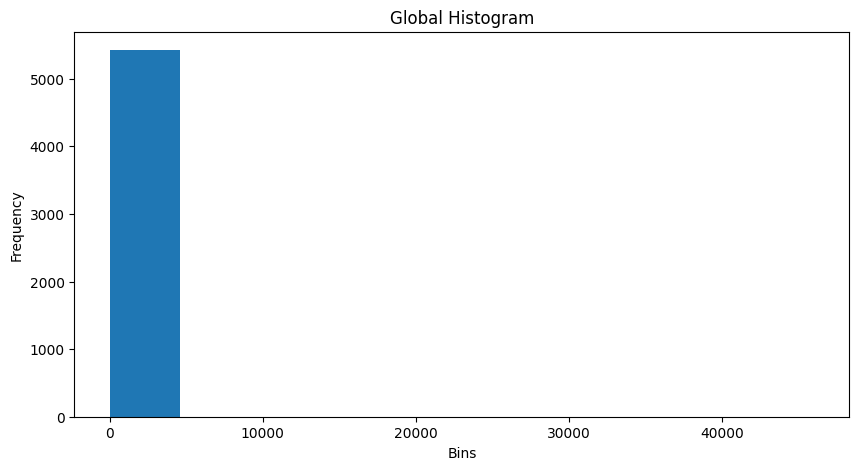

In [18]:
sample = X_test[1]
print(sample)

# show bar chart
plt.figure(figsize=(10, 5))
plt.hist(sample.ravel())
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Global Histogram')
plt.show()

## Training Random Forest LBP

In [19]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': 123,
}

rf = RandomForestClassifier(**rf_params)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
test_acc_rf = np.mean(y_pred_rf == y_test)
print(f"Random Forest Accuracy: {test_acc_rf * 100:.2f}%")

Random Forest Accuracy: 64.15%


In [20]:
# convert class to 0...
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

In [27]:
from xgboost import XGBClassifier

xgb_params = {
    'objective': 'multi:softmax',
    'num_class': len(np.unique(y_train)),
    'eval_metric': 'merror',
    'eta': 0.1,
    'max_depth': 30,
    'gamma': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 123,
    'n_estimators': 200,
}

xgb = XGBClassifier(**xgb_params)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
test_acc_xgb = np.mean(y_pred_xgb == y_test)
print(f"XGBoost Accuracy: {test_acc_xgb * 100:.2f}%")

XGBoost Accuracy: 71.70%


In [30]:
# export xgb model
import joblib

joblib.dump(xgb, f"xgb_model_{test_acc_xgb * 100:.2f}.pkl")

['xgb_model_71.70.pkl']

## Training AUTOML Model

In [28]:
classes, counts = np.unique(y_train, return_counts=True)
print("Classes:", classes)
print("Counts per class:", counts)

Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]
Counts per class: [120 129 171 181 138 159 152 135 150 138 136 158 157 114 154 140 171 160
 168 172 115 128 135 125 151 124 129 133 154 161 163 139 162 108 124 143
 165 152 139 127 158 141 151 129 158 126 153 113 142 130 133 155 155]


In [29]:
# convert class to 0...
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

In [ ]:
from tpot import TPOTClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

xgboost_config = {
    'xgboost.XGBClassifier': {
        'objective': ['multi:softmax'],
        'num_class': [len(np.unique(y_train))],
        'eval_metric': ['merror', 'mlogloss'],
        'eta': [0.1, 0.3],
        'max_depth': [50],
        'gamma': [0.1, 0.3],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 1.0],
        'seed': [123],
        'n_estimators': [100, 200],
    }
}

# # Create a TPOTClassifier instance
# tpot = TPOTClassifier(
#     generations=5,  # Number of iterations for optimization
#     population_size=20,  # Number of pipelines per generation
#     verbosity=2,  # Level of logging verbosity
#     config_dict=xgboost_config,  # Use the custom config for XGBoost
#     random_state=42,
#     n_jobs=-1  # Use all available cores
# )

# rf_config = {
#     'sklearn.ensemble.RandomForestClassifier': {
#         'n_estimators': [50, 100, 200, 300],
#         'criterion': ['gini', 'entropy', 'log_loss'],
#         'max_depth': [None, 10, 20, 30],
#         'min_samples_split': [2, 5, 10],
#         'min_samples_leaf': [1, 2, 4],
#         'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
#         'max_features': ['auto', 'sqrt', 'log2'],
#         'max_leaf_nodes': [None, 10, 20, 30],
#         'min_impurity_decrease': [0.0, 0.1, 0.2],
#         'class_weight': ['balanced', 'balanced_subsample'],
#     }
# }

# Create a TPOTClassifier instance
tpot = TPOTClassifier(
    generations=5,  # Number of iterations for optimization
    population_size=20,  # Number of pipelines per generation
    verbosity=2,  # Level of logging verbosity
    config_dict=xgboost_config,  # Use the custom config for Random Forest
    random_state=42,
    cv=5,
    n_jobs=4
)

tpot.fit(X_train, y_train)

print(tpot.score(X_test, y_test))

is_classifier


d:\Tugazz\Coolyeah\PCD\TUBES\.venv\lib\site-packages\sklearn\base.py:1230: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(


                                                                                 
Generation 1 - Current best internal CV score: -inf


d:\Tugazz\Coolyeah\PCD\TUBES\.venv\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
d:\Tugazz\Coolyeah\PCD\TUBES\.venv\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, no

ValueError: n_splits=5 cannot be greater than the number of members in each class.

In [31]:
tpot.fitted_pipeline_

## Evaluate

XGB Accuracy: 71.70%


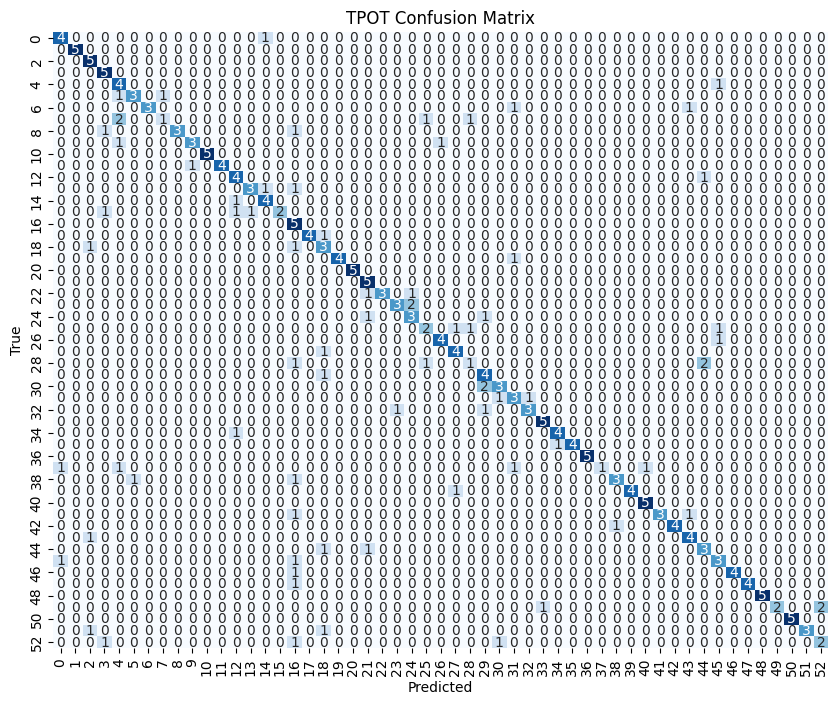

In [32]:
from sklearn.metrics import confusion_matrix

y_pred_xgb = xgb.predict(X_test)
test_acc_xgb = 0.0
fail_image_path = []
for i in range(len(y_pred_xgb)):
    if y_pred_xgb[i] == y_test[i]:
        test_acc_xgb += 1
    else:
        fail_image_path.append(test_df['filepaths'][i])

print(f"XGB Accuracy: {(test_acc_xgb/len(y_pred_xgb)  ) * 100:.2f}%")

conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot confusion matrix for TPOT with label name on label dict
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('TPOT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [49]:
from PIL import Image

print(fail_image_path)
for i in range(len(fail_image_path)):
    img = Image.open(fail_image_path[i])
    # replace \\
    img_path = fail_image_path[i].replace('\\', '/').split('/')
    if not os.path.exists(os.path.join('./fail-img', img_path[-3], img_path[-2])):
        os.makedirs(os.path.join('./fail-img', img_path[-3], img_path[-2]))
    img.save('./fail-img' + fail_image_path[i][1:])

['./test/ace of clubs\\3.jpg', './test/eight of clubs\\2.jpg', './test/eight of diamonds\\3.jpg', './test/eight of diamonds\\5.jpg', './test/eight of hearts\\2.jpg', './test/eight of hearts\\5.jpg', './test/eight of spades\\2.jpg', './test/eight of spades\\3.jpg', './test/eight of spades\\4.jpg', './test/eight of spades\\5.jpg', './test/five of clubs\\2.jpg', './test/five of clubs\\3.jpg', './test/five of diamonds\\4.jpg', './test/five of diamonds\\5.jpg', './test/five of spades\\4.jpg', './test/four of clubs\\1.jpg', './test/four of diamonds\\4.jpg', './test/four of diamonds\\5.jpg', './test/four of hearts\\3.jpg', './test/four of spades\\2.jpg', './test/four of spades\\3.jpg', './test/four of spades\\4.jpg', './test/jack of diamonds\\3.jpg', './test/jack of hearts\\2.jpg', './test/jack of hearts\\5.jpg', './test/jack of spades\\3.jpg', './test/king of diamonds\\3.jpg', './test/king of diamonds\\4.jpg', './test/king of hearts\\1.jpg', './test/king of hearts\\2.jpg', './test/king of sp

TPOT Accuracy: 61.89%


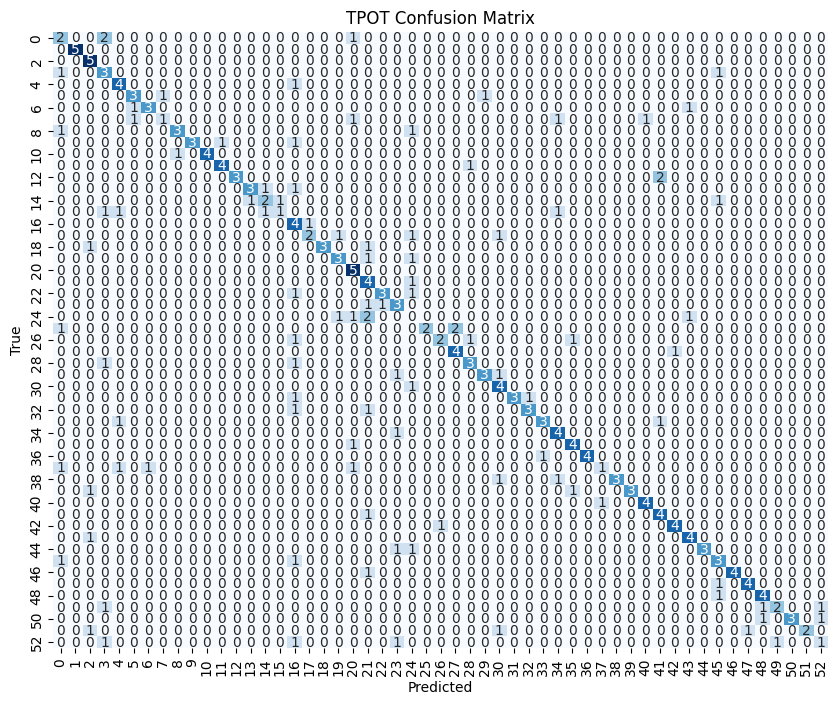

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_tpot = tpot.predict(X_test)
test_acc_tpot = 0.0
fail_image_path = []
for i in range(len(y_pred_tpot)):
    if y_pred_tpot[i] == y_test[i]:
        test_acc_tpot += 1
    else:
        fail_image_path.append(test_df['filepaths'][i])

print(f"TPOT Accuracy: {(test_acc_tpot/len(y_pred_tpot)  ) * 100:.2f}%")

conf_matrix_tpot = confusion_matrix(y_test, y_pred_tpot)

# Plot confusion matrix for TPOT with label name on label dict
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_tpot, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('TPOT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# save failed images
for image in fail_image_path:
    img = cv2.imread(image)
    cv2.imwrite(f'./failed_images/{image.split("/")[-1]}', img)
    


NameError: name 'fail_image_path' is not defined

In [54]:
# load pickle model
import joblib

xgb = joblib.load('xgb_model_71.70.pkl')

# predict
y_pred_xgb = xgb.predict(X_train)
train_acc_xgb = np.mean(y_pred_xgb == y_train)
# check inference time
import time
tic = time.time()
y_pred_xgb = xgb.predict(X_train)
toc = time.time()
inference_time = toc - tic
train_acc_xgb = np.mean(y_pred_xgb == y_train)
print(f"XGBoost Accuracy: {train_acc_xgb * 100:.2f}%")
print(f"Inference time: {inference_time:.4f} seconds")
img_per_second = len(X_train) / inference_time
print(f"Images per second: {img_per_second:.2f}")

XGBoost Accuracy: 99.99%
Inference time: 0.3610 seconds
Images per second: 21119.18


In [ ]:
# ts_length = len(test_df)
# test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
# test_steps = ts_length // test_batch_size
# train_score = model.evaluate(train_generator, steps= test_steps, verbose= 1)
# valid_score = model.evaluate(valid_generator, steps= test_steps, verbose= 1)
# test_score = model.evaluate(test_generator, steps= test_steps, verbose= 1)

# print("Train Loss: ", train_score[0])
# print("Train Accuracy: ", train_score[1])
# print('-' * 20)
# print("Validation Loss: ", valid_score[0])
# print("Validation Accuracy: ", valid_score[1])
# print('-' * 20)
# print("Test Loss: ", test_score[0])
# print("Test Accuracy: ", test_score[1])

In [ ]:
# y_true=test_generator.labels
# y_pred= []
# preds=model.predict(test_generator, verbose=1)
# classes=list(test_generator.class_indices.keys())
# class_count=len(classes)
# for i, p in enumerate(preds):
#     pred_index=np.argmax(p)
#     true_index=test_generator.labels[i]
#     y_pred.append(pred_index)

# cm = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(18, 11))
# sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
# plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
# plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

# clr = classification_report(y_true, y_pred, target_names=classes, digits= 4)
# print("Classification Report:\n----------------------\n", clr)

In [ ]:
# one_img = cv2.imread('/content/test/five of clubs/1.jpg')
# label = list(train_generator.class_indices.keys())
# plt.imshow(one_img)
# plt.show()
# one_img = one_img/255
# one_img = np.expand_dims(one_img, 0)
# one_pred = model.predict(one_img)
# one_pred = np.argmax(one_pred)
# print("Predicted label:",label[one_pred])

## Save model

In [ ]:
# class_dict = train_generator.class_indices
# height = []
# width = []
# for _ in range(len(class_dict)):
#     height.append(img_size[0])
#     width.append(img_size[1])

# Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
# Class_series = pd.Series(list(class_dict.keys()), name= 'class')
# Height_series = pd.Series(height, name= 'height')
# Width_series = pd.Series(width, name= 'width')
# class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
# subject = 'Cards-Classification'
# csv_name = f'{subject}-class_dict.csv'
# csv_save_loc = os.path.join('/content/drive/MyDrive/Dataset/Card-classification/', csv_name)
# class_df.to_csv(csv_save_loc, index= False)
# print(f'class csv file was saved as {csv_save_loc}')

In [ ]:
# loss, accuracy = model.evaluate(test_generator)
# name = f"CardClassification-MobileNet-(224x224)-{(accuracy*100):.2f}.h5"
# model.save(f'/content/drive/MyDrive/Dataset/Card-classification/{name}')
# print(f"Model saved as {name} in /content/drive/MyDrive/Dataset/Card-classification")